<a href="https://colab.research.google.com/github/Rakshan404/Quantum_Option_Pricing/blob/main/Quantum_Option_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install qiskit qiskit-aer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.2 MB/s eta 0:00:00


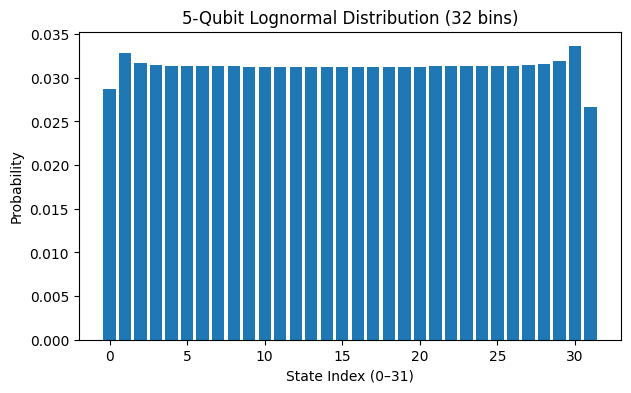


📌 Classical Expected Payoff: 19.347988277798493
📌 Classical Option Price: 19.15547257781525
Quantum Circuit Constructed ✓

🎯 FINAL RESULTS
📌 Classical price: 19.15547257781525
📌 Quantum estimated price: 18.087617308780402
📌 Difference: 1.0678552690348475


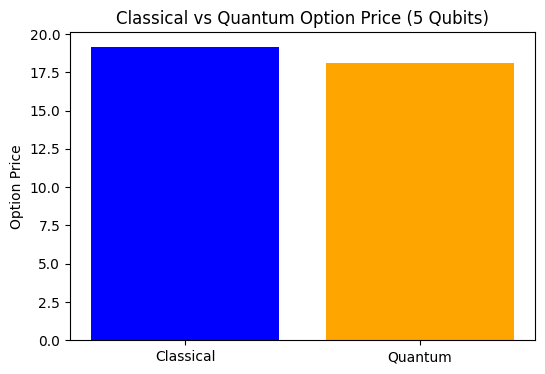

In [5]:

import numpy as np
from scipy.special import erfinv
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit                # Main Qiskit circuit class
from qiskit.quantum_info import Statevector      # For debugging state amplitudes
from qiskit.circuit.library import Initialize    # Used to load custom probability amplitudes
from qiskit_aer import AerSimulator              # Qiskit Aer Simulator backend

from math import erf, sqrt

# These control the financial model and the quantum circuit resolution.
# The initial stock price can be varied according to the users desire

S0 = 100.0         # Current stock price
K = 100.0          # Strike price
r = 0.01           # Annual risk-free interest rate (1%)
T = 1.0            # Maturity time in years (1 year)
sigma = 0.5        # Volatility (50%)
n_qubits = 5       # 5 data qubits → 32 possible price outcomes
shots = 5000       # Number of samples from quantum circuit

# Quantum computers cannot represent continuous distributions,
# so we discretize the lognormal distribution into 2^n bins.

num_states = 2**n_qubits      # For 5 qubits → 32 states

# Midpoints inside each probability bin (inverse transform sampling)
ps = np.linspace(0.5/num_states, 1 - 0.5/num_states, num_states)

# Parameters of lognormal distribution under risk-neutral measure
mu = np.log(S0) + (r - 0.5*sigma**2)*T
sd = sigma * np.sqrt(T)

# Convert quantiles (uniform ps) into lognormal prices
S_T_vals = np.exp(mu + sd * np.sqrt(2) * erfinv(2*ps - 1))


def lognormal_cdf(x):
    """Numerically stable lognormal CDF for probability bin integration."""
    if x <= 0:
        return 0.0
    z = (np.log(x) - mu) / sd
    return 0.5 * (1 + erf(z / np.sqrt(2)))

# Bin edges (midpoints between adjacent S_T_vals)
edges = np.concatenate((
    [0],
    (S_T_vals[:-1] + S_T_vals[1:]) / 2,
    [S_T_vals[-1] * 2]
))

# Probability of each bin = CDF difference
probs = np.array([
    lognormal_cdf(edges[i+1]) - lognormal_cdf(edges[i])
    for i in range(num_states)
])
probs = probs / probs.sum()   # Normalize to exactly 1.0


# Plot discretized distribution

plt.figure(figsize=(7,4))
plt.bar(range(num_states), probs)
plt.title("5-Qubit Lognormal Distribution (32 bins)")
plt.xlabel("State Index (0–31)")
plt.ylabel("Probability")
plt.show()

# This gives the true benchmark value (discounted payoff expectation).

# Payoff for each discretized stock price
payoffs = np.maximum(S_T_vals - K, 0)

# Expected payoff under classical lognormal binning
expected_payoff_classical = np.dot(probs, payoffs)

# Discount to present value
classical_price = np.exp(-r*T) * expected_payoff_classical

print("\n📌 Classical Expected Payoff:", expected_payoff_classical)
print("📌 Classical Option Price:", classical_price)

# The quantum circuit’s amplitude encoding loads √probabilities into qubit amplitudes.

amps = np.sqrt(probs)              # Quantum amplitudes = sqrt(probabilities)
amps = amps / np.linalg.norm(amps) # Numerical renormalization

# "Initialize" gate loads custom amplitude distribution into the qubits
init = Initialize(amps)

# Add 1 ancilla qubit for payoff marking: total = data qubits + 1
qc = QuantumCircuit(n_qubits + 1, 1)

# Load probability amplitudes into the 5 data qubits
qc.append(init, range(n_qubits))

# For each basis state |i⟩ corresponding to a stock price S_T_vals[i],
# we apply a multi-controlled RY rotation on the ancilla qubit.
# The more payoff, the larger the rotation → encodes payoff probability.

max_payoff = payoffs.max()      # Needed to normalize controlled rotations

for idx in range(num_states):

    payoff = payoffs[idx]                        # payoff for specific bin
    payoff_norm = payoff / max_payoff if max_payoff > 0 else 0
    payoff_norm = np.clip(payoff_norm, 0, 1)     # avoid floating errors

    # Convert payoff into a rotation angle (encoding amplitude)
    # ancilla amplitude = sqrt(payoff_norm)
    theta = 2 * np.arcsin(np.sqrt(payoff_norm))

    if theta == 0:    # skip bins with zero payoff (simplifies circuit)
        continue

    # Convert basis index to binary (e.g., 01011)
    bits = format(idx, f'0{n_qubits}b')

    # Activate X gates to match the basis state as control
    for q, bit in enumerate(reversed(bits)):
        if bit == "0":          # flip qubit if state requires |1⟩ control
            qc.x(q)

    # Apply multi-controlled RY on ancilla qubit (qubit n_qubits)
    qc.mcry(theta, list(range(n_qubits)), n_qubits)

    # Undo X gates to restore original states
    for q, bit in enumerate(reversed(bits)):
        if bit == "0":
            qc.x(q)

# Measure ancilla only (stores payoff amplitude)
qc.measure(n_qubits, 0)

print("Quantum Circuit Constructed ✓")

# The ancilla qubit probability p(1) encodes expected payoff / max_payoff.

backend = AerSimulator()
job = backend.run(qc, shots=shots)
counts = job.result().get_counts()

# Probability of measuring ancilla = 1
p1 = counts.get("1", 0) / shots

# Convert ancilla expectation back to payoff scale
expected_payoff_quantum = p1 * max_payoff
quantum_price = np.exp(-r*T) * expected_payoff_quantum

print("\n🎯 FINAL RESULTS")
print("📌 Classical price:", classical_price)
print("📌 Quantum estimated price:", quantum_price)
print("📌 Difference:", abs(quantum_price - classical_price))

plt.figure(figsize=(6,4))
plt.bar(["Classical", "Quantum"], [classical_price, quantum_price], color=['blue','orange'])
plt.title("Classical vs Quantum Option Price (5 Qubits)")
plt.ylabel("Option Price")
plt.show()
